In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cbsodata
from plotly.offline import init_notebook_mode
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import folium
import json

In [2]:
# Load Datasets
data_lic_temp   = pd.DataFrame(cbsodata.get_data('83488ENG', 
                        dir = 'C:/Users/Jochi/TIL6022-LabAssignments-group-11/Data')) # People with a driving licence
#data_traffic = pd.DataFrame(cbsodata.get_data('84707ENG')) # Mobility, traffic participation
#data_travel = pd.DataFrame(cbsodata.get_data('84713ENG')) # Mobility per person, travel characteristics

In [3]:
df_pop_temp = pd.DataFrame(cbsodata.get_data('7461ENG'))   # Insert dataset with population data

In [12]:
# Get Datasets.
data_lic = data_lic_temp
df_pop = df_pop_temp

# Get list of the years from driving licence and filter these years from population dataset.
years = list(set(data_lic.Periods.values))
years = np.sort(years)
df_pop = df_pop[df_pop['Periods'].isin(years)]

# Filter age groups required for driving licence dataset.
ages = data_lic.AgeDrivingLicenseHolder.values
ages = list(set(ages))
ages_not = ['16 to 17 years','Age unknown', 'Total']
ages = [x for x in ages if x not in ages_not]
ages = np.sort(ages)

# Filter age groups required for population dataset.
ages_pop = ['18 years', '19 years', '20 to 25 years', '25 to 30 years', '30 to 40 years',
            '40 to 50 years', '50 to 60 years', '60 to 65 years', '65 to 70 years', 
            '70 to 75 years', '75 to 80 years', '80 to 90 years', '90 years or older']
df_pop = df_pop[df_pop['Age'].isin(ages_pop)]

# Map driving licence age groups on population age groups and replace.
df_pop = df_pop[df_pop['Sex'] == 'Men and women']
mapping = {
            '18 years':'18 to 19 years',
            '19 years':'18 to 19 years',
            '20 to 25 years':'20 to 24 years',
            '25 to 30 years':'25 to 29 years',
            '30 to 40 years':'30 to 39 years',
            '40 to 50 years':'40 to 49 years',
            '50 to 60 years':'50 to 59 years',
            '60 to 65 years':'60 to 64 years',
            '65 to 70 years':'65 to 69 years',
            '70 to 75 years':'70 to 74 years' ,
            '75 to 80 years':'75 years or older', 
            '80 to 90 years':'75 years or older', 
            '90 years or older':'75 years or older',
}
df_pop['Age'].replace(mapping, inplace=True)

# Filter types of cars for driving licence dataset.
sorts = data_lic.CategoryDrivingLicence.values
sorts = list(set(sorts))
cars = ['Moped driving licence', 'Passenger car licence incl. trailer', 
        'Passenger car licence excl. trailer', 'Passenger car driving licence total', ]
large_cars= [x for x in sorts if x not in cars]

# Filter Dutch regions for driving licence dataset.
regions = data_lic.Region.values
regions = list(set(regions))
no_province= ['Noord-Nederland (LD)','Nederland', 'Oost-Nederland (LD)', 'Zuid-Nederland (LD)', 
              'Unclassifiable (LD)', 'West-Nederland (LD)']
provinces = [x for x in regions if x not in no_province]

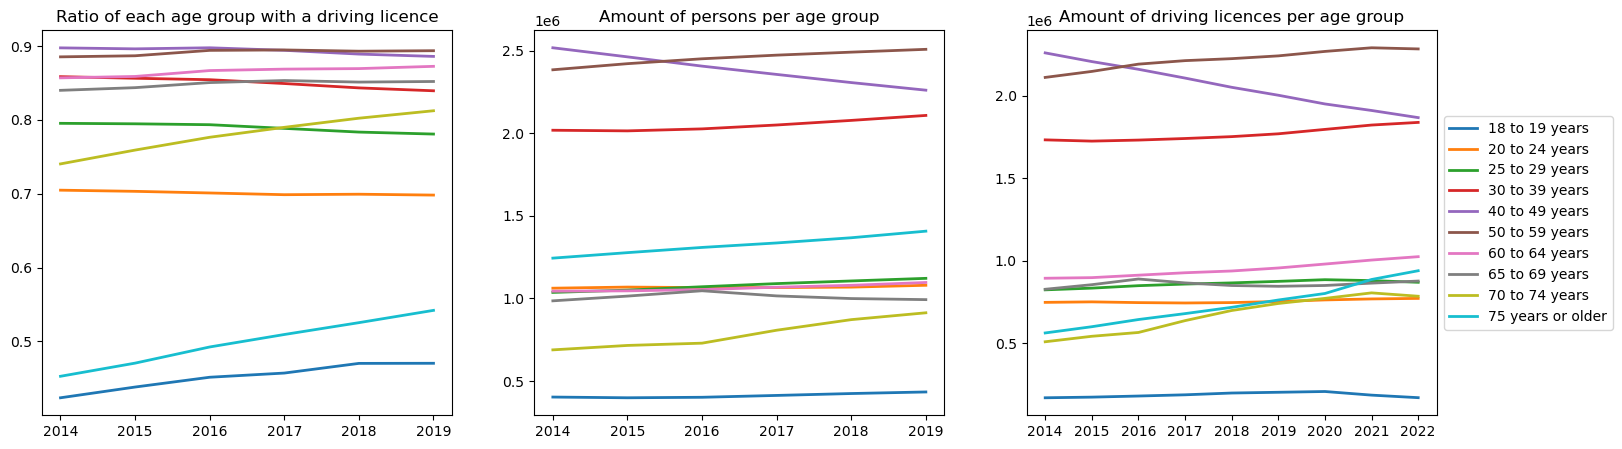

In [13]:
# create figure for three subplots.
f = plt.figure(figsize=(18, 5)) 

# Filter dataset on total data, per age group for passenger cars.
for i in range(len(ages)):
    data_lic_tot = data_lic[(data_lic.Region == 'Nederland')
                        & (data_lic.AgeDrivingLicenseHolder == ages[i])
                        & (data_lic.CategoryDrivingLicence == 'Passenger car driving licence total')]
    data_lic_tot.PeopleWithADrivingLicence_1.astype(int) # convert data to integer

# Group population data per age and year.
    df_pop_tot = df_pop[(df_pop.Age == ages[i])]
    df_pop_new = df_pop_tot.groupby(['Periods']).sum()

# Create new column for the ratio of driving licences per age group.
    x = np.zeros(len(df_pop_new))
    for j in range(len(df_pop_new)):
        x[j]= data_lic_tot.iloc[j, 5] / df_pop_new.iloc[j, 1]
    df_pop_new['Ratio'] = x

# Plot data of Ratio of driving licences per age group.
    plt.subplot(1, 3, 1)
    plt.plot(data_lic_tot.Periods[0:6], df_pop_new.Ratio, label=ages[i], linewidth=2)
    plt.title('Ratio of each age group with a driving licence')

# Plot data of total persons per age group over the years.
    plt.subplot(1, 3, 2)
    plt.plot(data_lic_tot.Periods[0:6], df_pop_new.TotalPopulation_1, label = ages[i], linewidth =2)
    plt.title('Amount of persons per age group')
    
# Filter dataset on total data, per age group for passenger cars.
plt.subplot(1, 3, 3)
for i in range(len(ages)):
    data_lic_tot = data_lic[(data_lic.Region == 'Nederland')
                        & (data_lic.AgeDrivingLicenseHolder == ages[i])
                        & (data_lic.CategoryDrivingLicence == 'Passenger car driving licence total')]
    
# Plot data of total driving licences per age group over the years.
    plt.plot(data_lic_tot.Periods, data_lic_tot.PeopleWithADrivingLicence_1, label=ages[i], 
             linewidth =2)
plt.title('Amount of driving licences per age group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

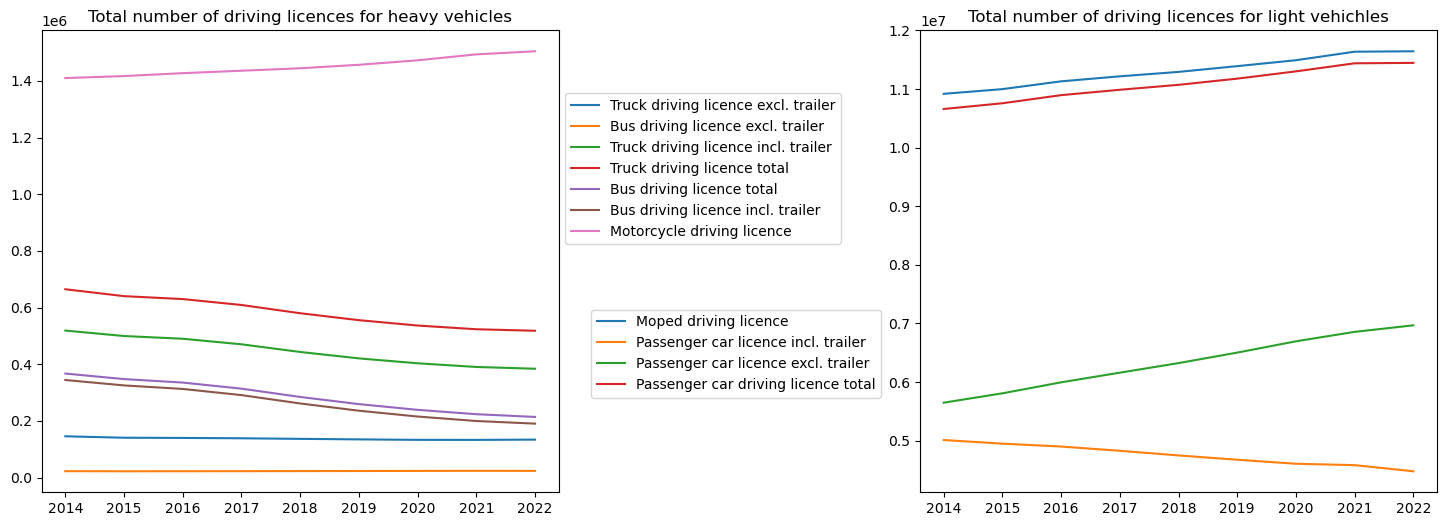

In [14]:
# Create figure and whitespace for legends
f = plt.figure(figsize=(18, 6))    
plt.subplots_adjust(wspace=0.7)

# Filter data and plot for Heavy vehicles.
plt.subplot(1,2,1)
for i in range(len(large_cars)):
    data_lic_tot = data_lic[(data_lic.Region == 'Nederland')
                        & (data_lic.AgeDrivingLicenseHolder == 'Total')
                        & (data_lic.CategoryDrivingLicence == large_cars[i])]
    
    plt.plot(data_lic_tot.Periods, data_lic_tot.PeopleWithADrivingLicence_1, label=large_cars[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.title('Total number of driving licences for heavy vehicles')

# Filter data and plot for light vehicles.
plt.subplot(1,2,2, )
for i in range(len(cars)):
    data_lic_tot = data_lic[(data_lic.Region == 'Nederland')
                        & (data_lic.AgeDrivingLicenseHolder == 'Total')
                        & (data_lic.CategoryDrivingLicence == cars[i])]
    
    plt.plot(data_lic_tot.Periods, data_lic_tot.PeopleWithADrivingLicence_1, label=cars[i])
plt.legend(loc='center left', bbox_to_anchor=(-0.65, 0.3))
plt.title('Total number of driving licences for light vehichles')
plt.show()

The plots above show the total number of driving licences for different vehicle types. Interestingly the licences for trucks and buses with a trailer are gradually lowering and therefore the total number of licences is getting lower. The licences for a truck and bus excl. a trailer stay the same. This change in licences could be due to the fact that more people with such a specific licence are retiring. New truck drivers might not need a licence where they can drive with a trailer as the demand for this is lower. Still, the number of drivers with a licence incl. a trailer is higher.



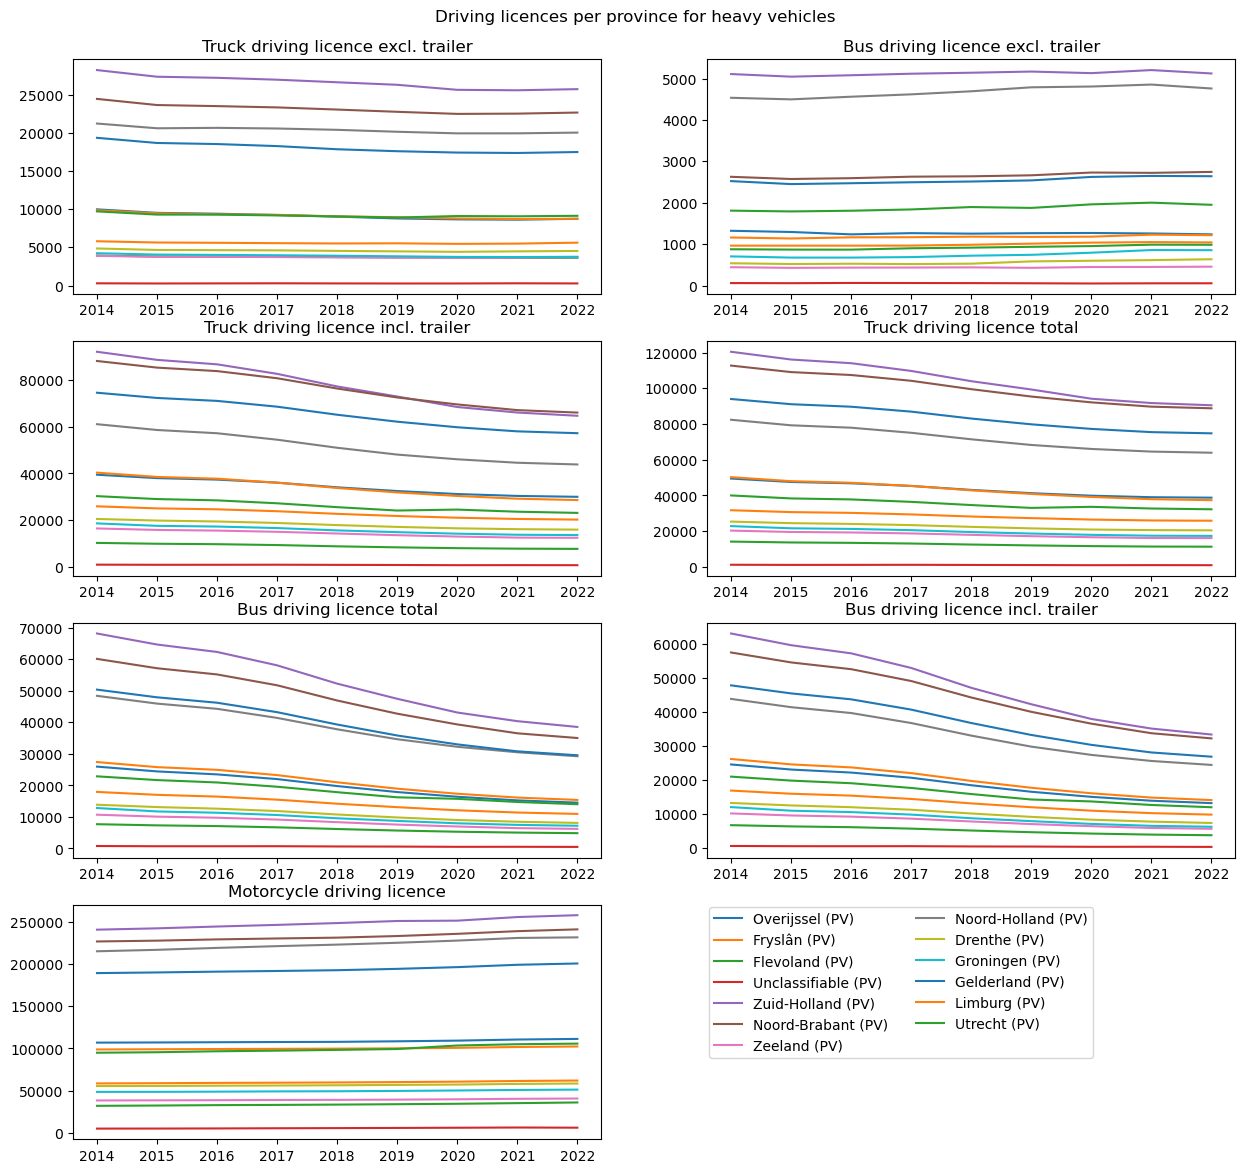

In [15]:
plt.figure(figsize=(15, 25))
for i in range(len(provinces)):
    for j in range(len(large_cars)) :
        plt.subplot(7, 2, j + 1)
        data_lic_tot = data_lic[(data_lic.Region == provinces[i])
                            & (data_lic.AgeDrivingLicenseHolder == 'Total')
                            & (data_lic.CategoryDrivingLicence == large_cars[j])]
        plt.plot(data_lic_tot.Periods, data_lic_tot.PeopleWithADrivingLicence_1, 
                 label=f'{provinces[i]}')
        plt.title(large_cars[j])
        #plt.ylim(0, 3e5)
    plt.legend( bbox_to_anchor=(1.19, 1.02), fancybox=True, ncol=2)
plt.suptitle('Driving licences per province for heavy vehicles', y=0.9)
plt.show()

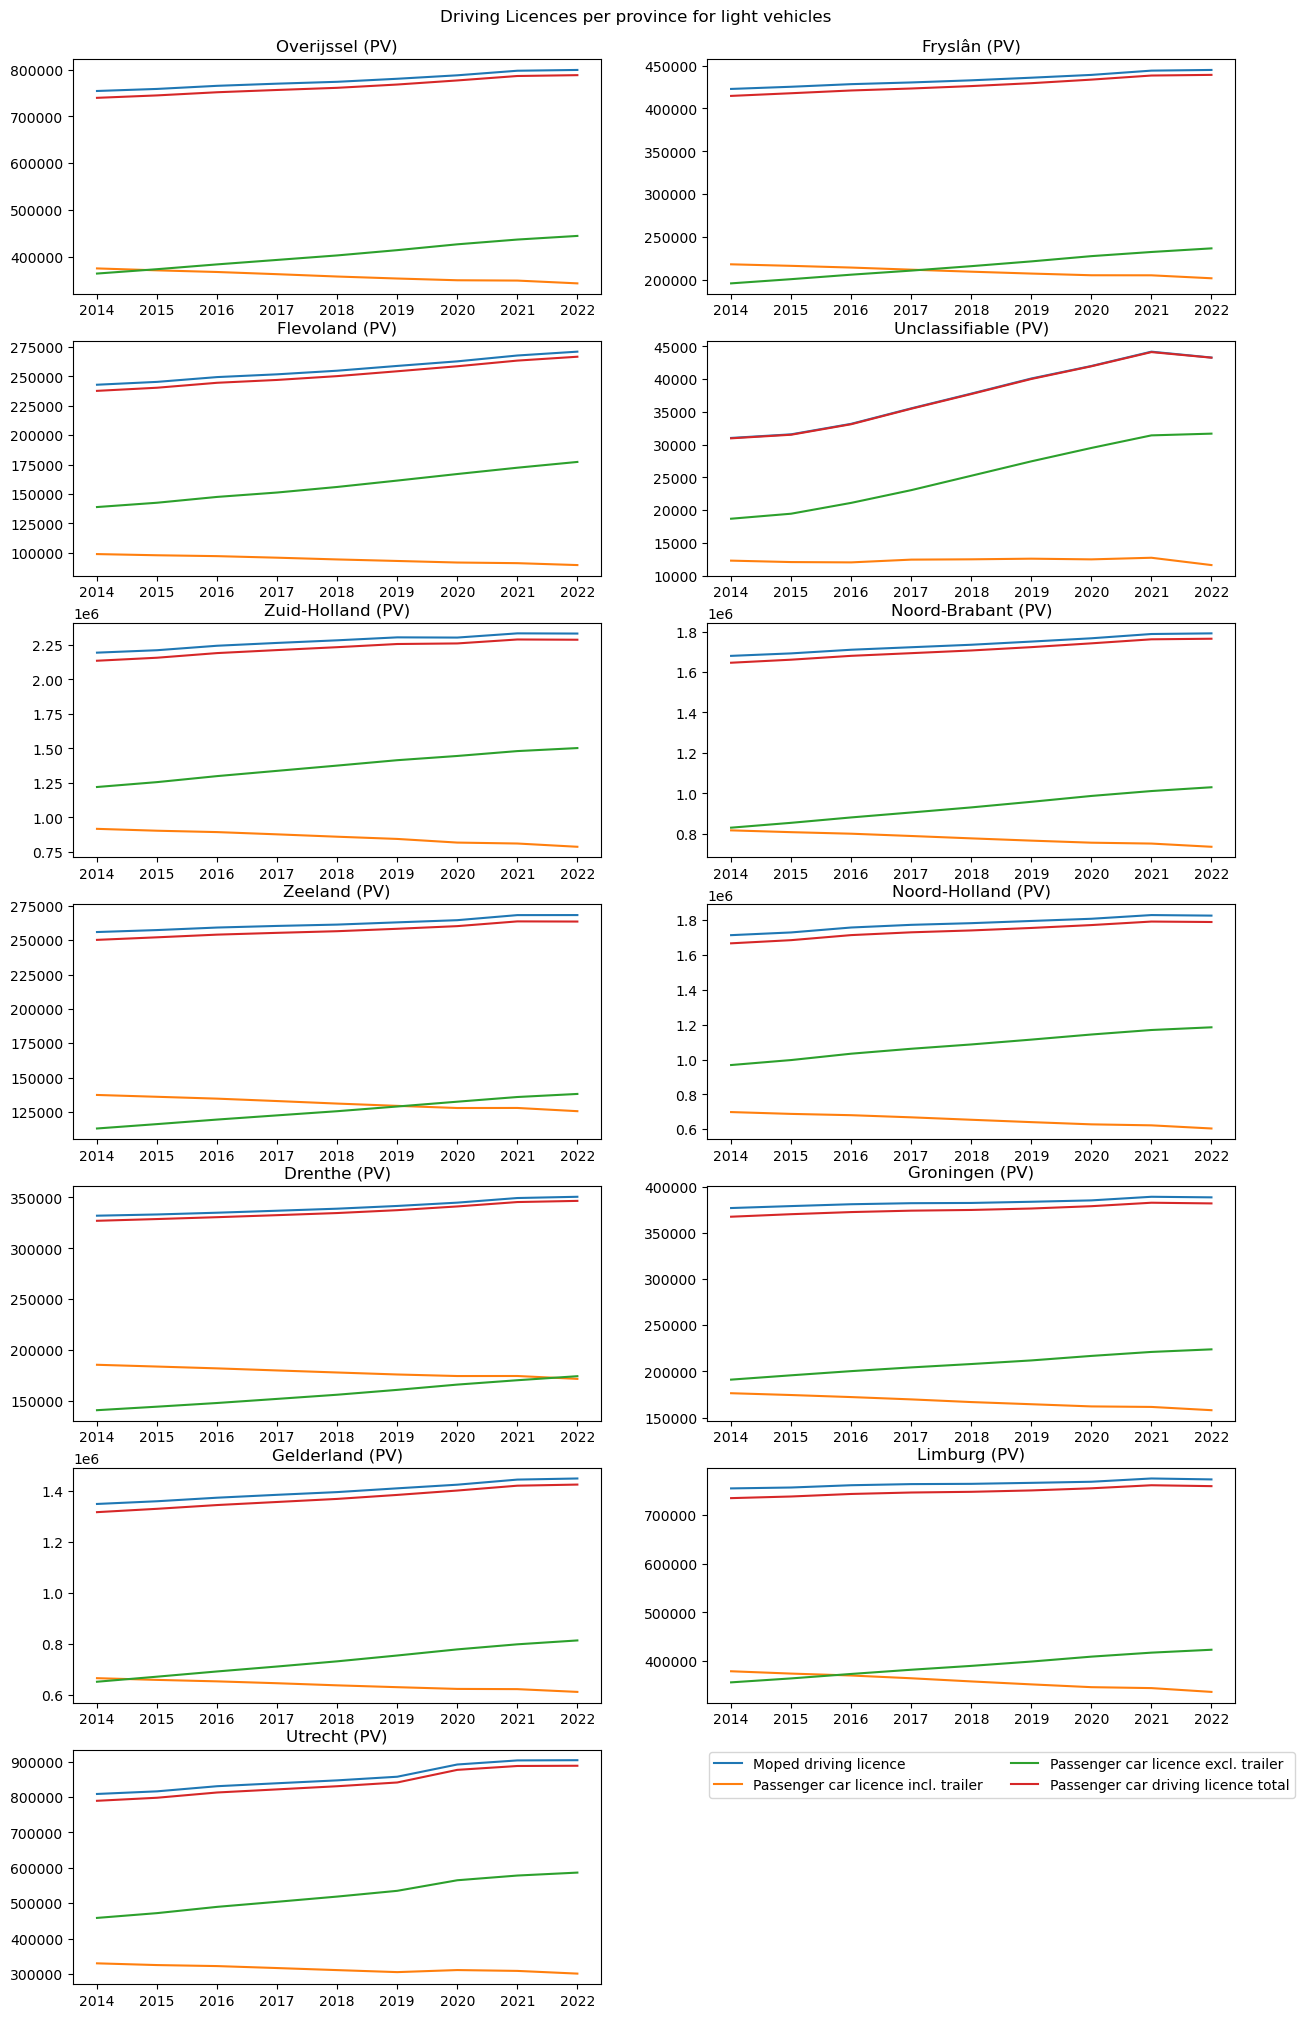

In [16]:
plt.figure(figsize=(15, 25))
for i in range(len(cars)):
    for j in range(len(provinces)) :
        plt.subplot(7, 2, j + 1)
        data_lic_tot = data_lic[(data_lic.Region == provinces[j])
                            & (data_lic.AgeDrivingLicenseHolder == 'Total')
                            & (data_lic.CategoryDrivingLicence == cars[i])]
        plt.plot(data_lic_tot.Periods, data_lic_tot.PeopleWithADrivingLicence_1, 
                 label=f'{cars[i]}')
        plt.title(provinces[j])
    plt.legend( bbox_to_anchor=(1.19, 1.02), fancybox=True, ncol=2)
plt.suptitle('Driving Licences per province for light vehicles', y=0.9)
plt.show()

In [17]:
fig = go.Figure(data=go.Choropleth(
    locations = df_usa['fips'],
    geojson=counties,
    z = df_usa['unemp'],
    zmin=0,
    zmax=12,
    colorscale = 'Viridis',
    autocolorscale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Unemployment Rate'
))

fig.update_layout(
    title_text='Unemployment Rate',
    geo_scope='usa', # limite map scope to USA
    geo=dict(
        showframe=False,
        showcoastlines=False
    )
)

fig.show()

NameError: name 'df_usa' is not defined

In [22]:
provinces = json.load('provinces.geojson')

AttributeError: 'str' object has no attribute 'read'